## Поиск аномалий в данных

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
data = pd.read_csv('creditcard.csv')

In [9]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Работаем с датасетом о банковских транзакциях. Все признаки анонимизированы и уже масштабированы. В последнем столбце Class 1 характеризует аномальную тразнакцию.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Очистка датасета не требуется.

In [11]:
data.Class.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

Аномальный транзакций всего 0,17 %.

**Для дальнейшей работы уменьшаем датасет в 10 раз, стратифицируя по целевой переменной Class. Иначе визуализация TSNE и алгоритм DBSCAN вообще не завершаются.**

In [12]:
data = data.groupby('Class').apply(lambda x: x.sample(frac=0.1, random_state=100))

Убедимся, что процент аномальных транзакций остался тем же.

In [13]:
data.Class.value_counts(normalize=True)

0    0.99828
1    0.00172
Name: Class, dtype: float64

Сохраним в переменные этот процент.

In [14]:
expert_score = data.Class.value_counts(normalize=True)[1]
expert_score

0.0017204452090867595

In [15]:
percent_expert_score = expert_score*100

In [16]:
data.Class.value_counts()

0    28432
1       49
Name: Class, dtype: int64

В урезанном датасете 49 аномальных транзакций.

In [17]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,28481.000000,28481.000000,28481.000000,28481.000000,28481.000000,28481.000000,28481.000000,28481.000000,28481.000000,28481.000000,...,28481.000000,28481.000000,28481.000000,28481.000000,28481.000000,28481.000000,28481.000000,28481.000000,28481.000000,28481.000000
mean,94596.949124,-0.010565,0.004932,0.003139,-0.004943,-0.004815,-0.002788,0.010882,0.001935,-0.002441,...,-0.002881,0.002633,0.004884,-0.000487,0.003797,0.002660,0.000388,0.004472,88.959729,0.001720
std,47595.338598,1.980152,1.710139,1.512243,1.415798,1.390611,1.329697,1.262978,1.196030,1.101238,...,0.740529,0.725488,0.657598,0.609066,0.524824,0.484979,0.406001,0.394424,249.735521,0.041443
min,2.000000,-56.407510,-72.715728,-26.871339,-5.071655,-42.147898,-26.160506,-41.506796,-39.688571,-13.434066,...,-21.453736,-5.607527,-30.269720,-2.790479,-6.429334,-1.855355,-8.358317,-9.617915,0.000000,0.000000
25%,53627.000000,-0.918109,-0.582318,-0.881258,-0.842076,-0.683833,-0.768274,-0.551561,-0.206023,-0.645756,...,-0.229361,-0.541561,-0.162476,-0.356123,-0.318247,-0.327027,-0.069894,-0.052181,5.850000,0.000000
50%,84853.000000,-0.000175,0.073043,0.178154,-0.026535,-0.052929,-0.274787,0.047988,0.024374,-0.052751,...,-0.027777,0.007479,-0.010893,0.043642,0.021757,-0.045623,0.002896,0.012201,22.220000,0.000000
75%,139168.000000,1.309188,0.807036,1.031350,0.735050,0.596023,0.400528,0.581929,0.328074,0.591879,...,0.185726,0.527022,0.147700,0.442144,0.353913,0.242738,0.093363,0.079623,75.650000,0.000000
max,172780.000000,2.430507,21.467203,4.226108,16.491217,34.801666,22.529298,36.677268,11.949530,9.272376,...,17.300479,8.361985,22.528412,4.022866,7.519589,3.067907,11.135740,33.847808,8360.000000,1.000000


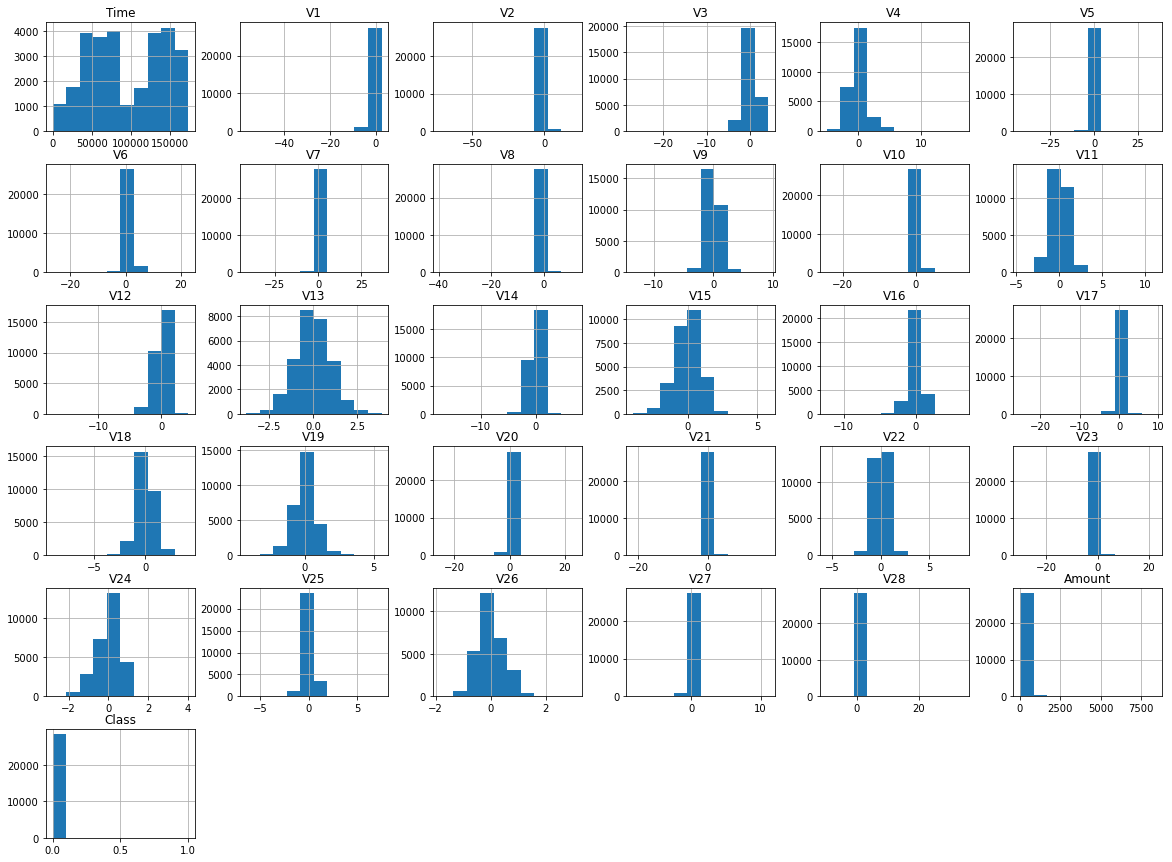

In [18]:
data.hist(figsize=(20,15));

Из описательных статистик и гистограмм значимой информации получить нельзя в связи с тем, что признаки анонимизированы.

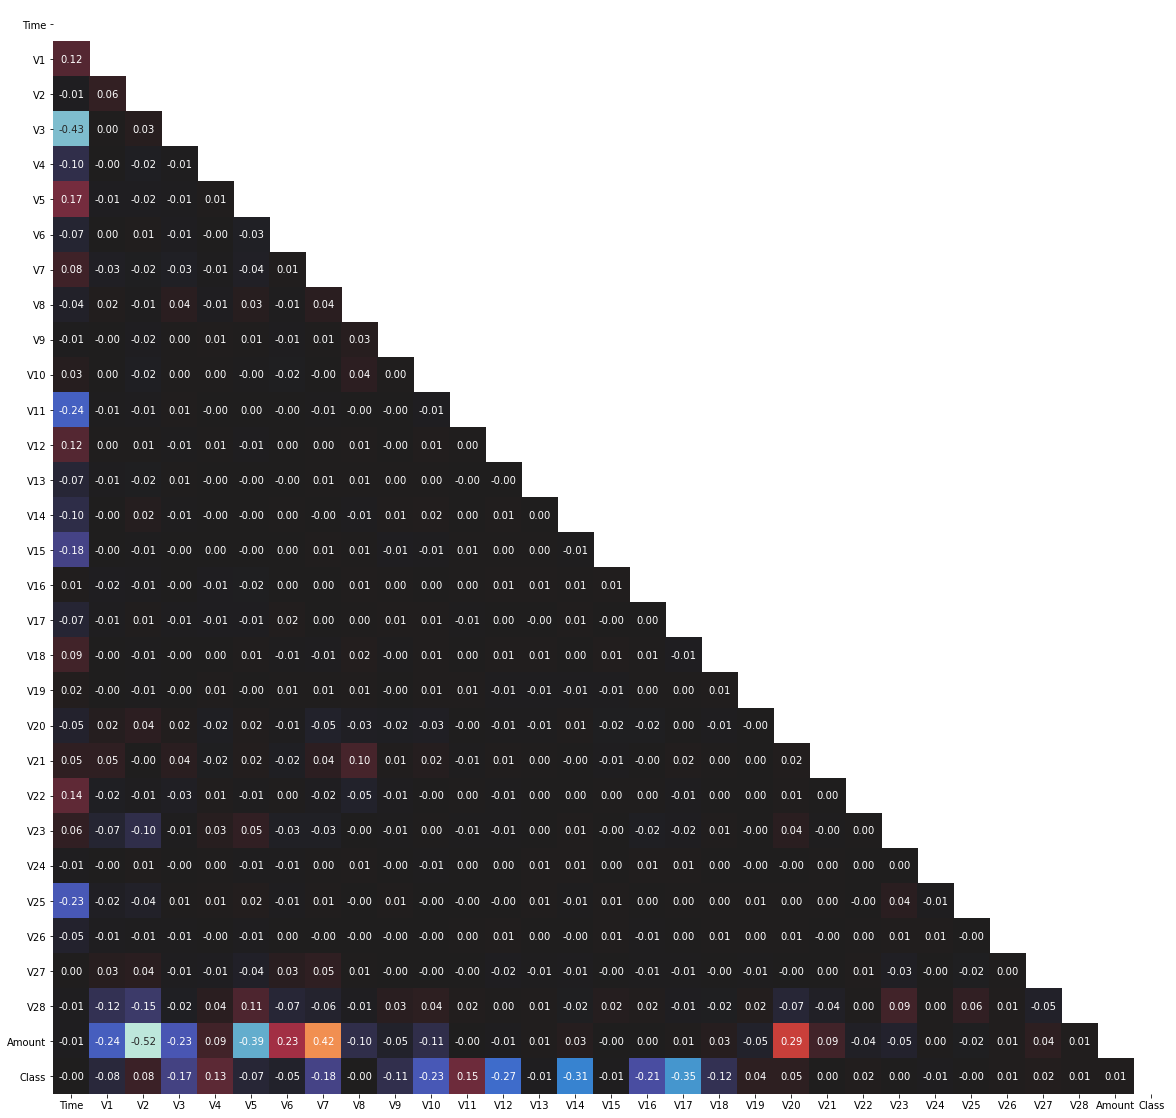

In [19]:
plt.figure(figsize=(20,20))

corr_matrix = data.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0);

Значимых корреляций тоже не наблюдается.

### Поиск по методу 3 сигм

Определим функции для поиска аномалий.

In [20]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [21]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns
        
    outliers = pd.Series(data=[False]*len(data), index=data_features.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    comparison_table = comparison_table.sort_values(by='anomalies_percentage', ascending=False)
    
    return comparison_table, outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))    

In [22]:
data_features = data.drop(['Time','Class'], axis=1)

In [23]:
comparison_table, std_outliers = get_column_outliers(data_features)
anomalies_report(std_outliers)

Total number of outliers: 3705
Percentage of outliers:   13.01%


Данный метод самый простой, и по нему целых 13% транзакций можно считать аномальными.

In [24]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
V27,1.218392,-1.217616,496.0,1.741512
V6,3.986303,-3.991879,444.0,1.558934
V20,2.349698,-2.346325,439.0,1.541378
Amount,838.166292,-660.246833,426.0,1.495734
V8,3.590024,-3.586155,408.0,1.432534
V21,2.218706,-2.224469,385.0,1.351778
V2,5.135348,-5.125484,376.0,1.320178
V7,3.799815,-3.778051,374.0,1.313156
V10,3.244887,-3.258013,363.0,1.274534
V1,5.929890,-5.951020,356.0,1.249956


In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
print(classification_report(data.Class, std_outliers))
confusion_matrix(data.Class, std_outliers)

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     28432
           1       0.01      0.92      0.02        49

    accuracy                           0.87     28481
   macro avg       0.51      0.89      0.48     28481
weighted avg       1.00      0.87      0.93     28481



array([[24772,  3660],
       [    4,    45]], dtype=int64)

Из таблицы метрик видно, что 45 из 49 аномальных транзакций распознаны, однако несколько тысяч нормальных тоже записаны в аномальные, что нас не устраивает.

### Поиск по межквартильному отклонению

Построим boxplot для каждого признака.

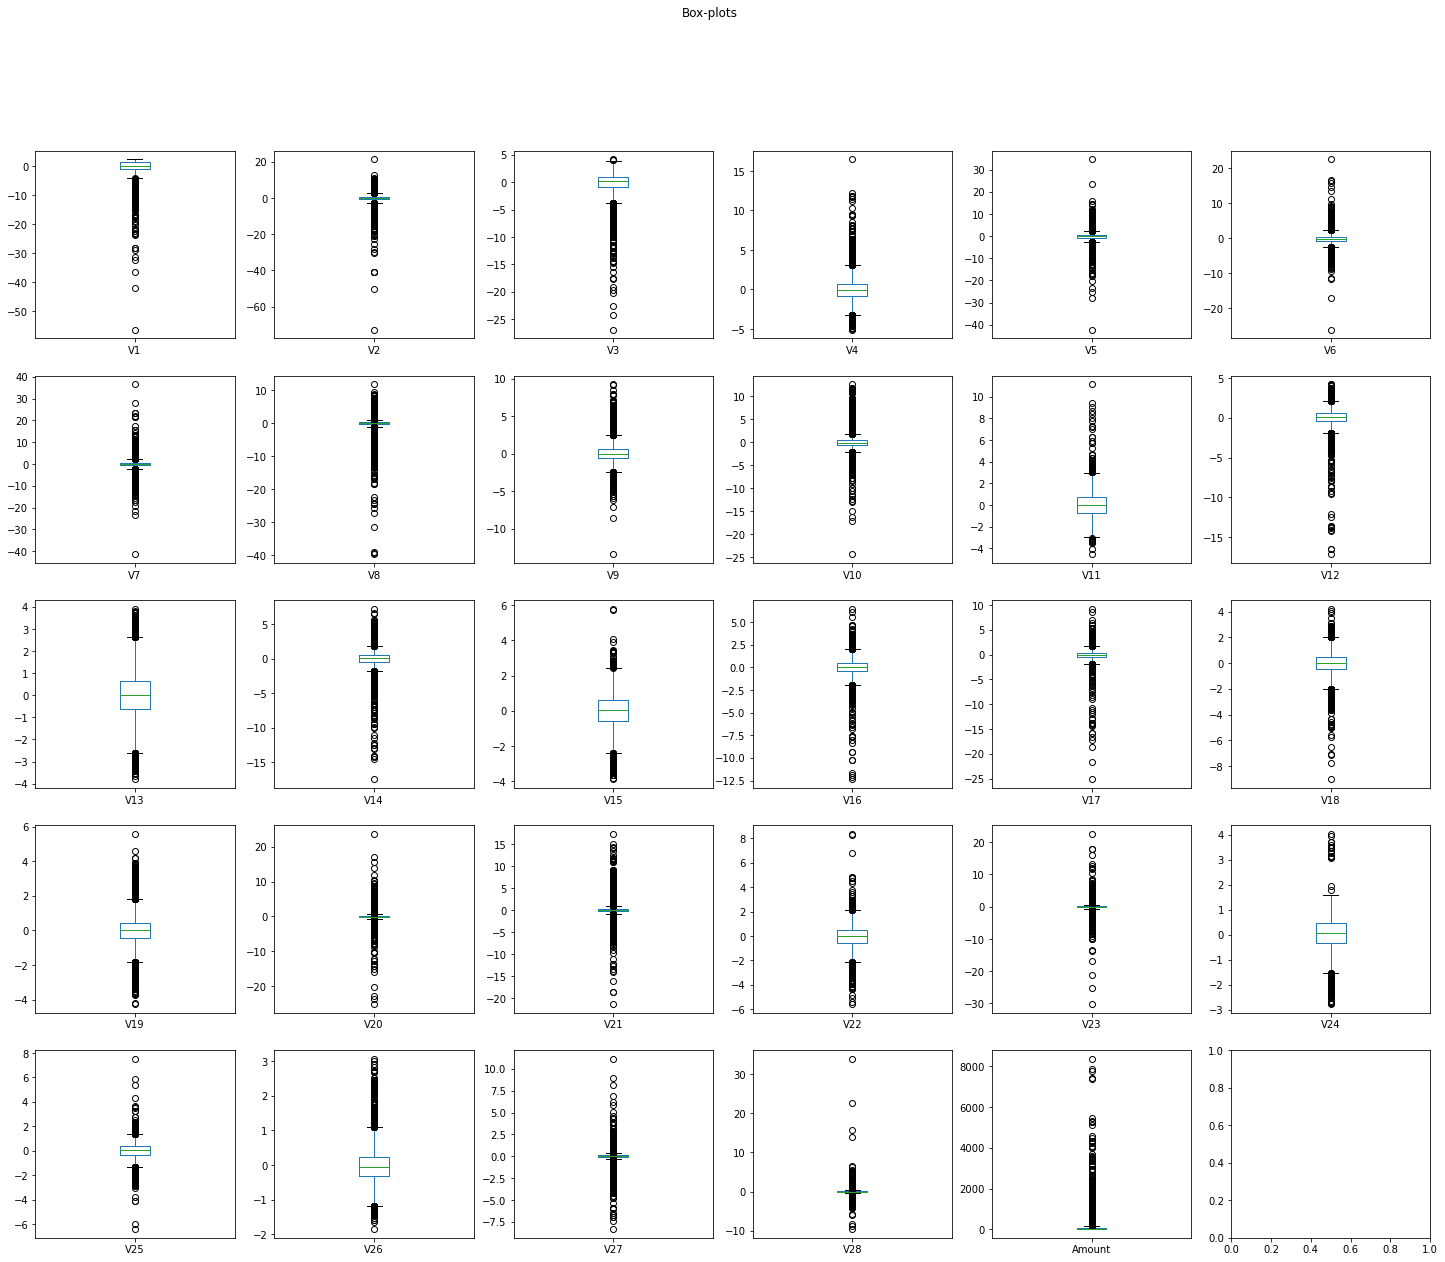

In [27]:
fig, axes = plt.subplots(5, 6, figsize=(25, 20))
fig.suptitle('Box-plots')

row=0
col=0

for ax, feature in enumerate(data_features):
    data_features[feature].plot.box(ax=axes[row, col])
    col+=1
    if col > 5:
        row+=1
        col=0

In [28]:
def outlier_iqr(data, col, threshold=3):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    up_bound = data[col].quantile(0.75) + (IQR * threshold)
    low_bound = data[col].quantile(0.25) - (IQR * threshold)
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [30]:
comparison_table, iqr_outliers = get_column_outliers(data_features, function=outlier_iqr)
anomalies_report(iqr_outliers)

Total number of outliers: 5353
Percentage of outliers:   18.79%


Здесь процент аномалий ещё выше, чем по 3 сигмам.

In [24]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
Amount,285.050000,-203.550000,1960.0,6.881781
V27,0.583136,-0.559667,1691.0,5.937292
V20,1.174421,-1.250381,1342.0,4.711913
V28,0.475037,-0.447595,1250.0,4.388891
V8,1.930367,-1.808315,1138.0,3.995646
V23,1.078230,-1.093005,813.0,2.854535
V21,1.430987,-1.474622,670.0,2.352445
V6,3.906935,-4.274682,499.0,1.752045
V2,4.975099,-4.750381,434.0,1.523823
V7,3.982398,-3.952030,344.0,1.207823


In [25]:
print(classification_report(data.Class, iqr_outliers))
confusion_matrix(data.Class, iqr_outliers)

              precision    recall  f1-score   support

           0       1.00      0.81      0.90     28432
           1       0.01      0.94      0.02        49

    accuracy                           0.81     28481
   macro avg       0.50      0.88      0.46     28481
weighted avg       1.00      0.81      0.90     28481



array([[23125,  5307],
       [    3,    46]], dtype=int64)

На одну аномальную транзакцию поймано больше, но количество ложноотрицательных очень велико.

### Distance-based clasterisation

In [26]:
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler

class DistanceOutliers(BaseEstimator):
    """
    -----------
    Parameters:
    
    - metric: string, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)
        
    - percentile: float in range [0, 100]
        hyperparameter which sets the threshold for anomalies
    """
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

Для работы с расстояниями данные необходимо привести к единому масштабу.

In [27]:
scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(data_features), 
    columns=data_features.columns
)

Отобразим данные на двумерной плоскости с помощью метода TSNE.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 28481 samples in 0.244s...
[t-SNE] Computed neighbors for 28481 samples in 36.143s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28481
[t-SNE] Computed conditional probabilities for sample 2000 / 28481
[t-SNE] Computed conditional probabilities for sample 3000 / 28481
[t-SNE] Computed conditional probabilities for sample 4000 / 28481
[t-SNE] Computed conditional probabilities for sample 5000 / 28481
[t-SNE] Computed conditional probabilities for sample 6000 / 28481
[t-SNE] Computed conditional probabilities for sample 7000 / 28481
[t-SNE] Computed conditional probabilities for sample 8000 / 28481
[t-SNE] Computed conditional probabilities for sample 9000 / 28481
[t-SNE] Computed conditional probabilities for sample 10000 / 28481
[t-SNE] Computed conditional probabilities for sample 11000 / 28481
[t-SNE] Computed conditional probabilities for sample 12000 / 28481
[t-SNE] Computed conditional probabilities for sa

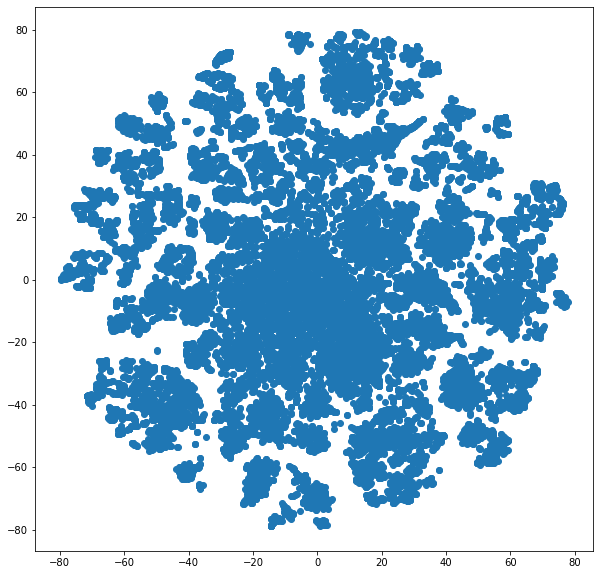

In [28]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_jobs=-1, verbose=2)
tsne_transformed = tsne.fit_transform(scaled_data)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1]);

Посчитаем, используя в качестве метрики евклидово расстояние и задав уже известный нам процент аномалий.

In [29]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=100-percent_expert_score)
euclidian_model.fit(scaled_data)
euclidian_outliers = euclidian_model.predict(scaled_data)
anomalies_report(euclidian_outliers)

Total number of outliers: 49
Percentage of outliers:   0.17%


Отобразим выявленные аномалии.

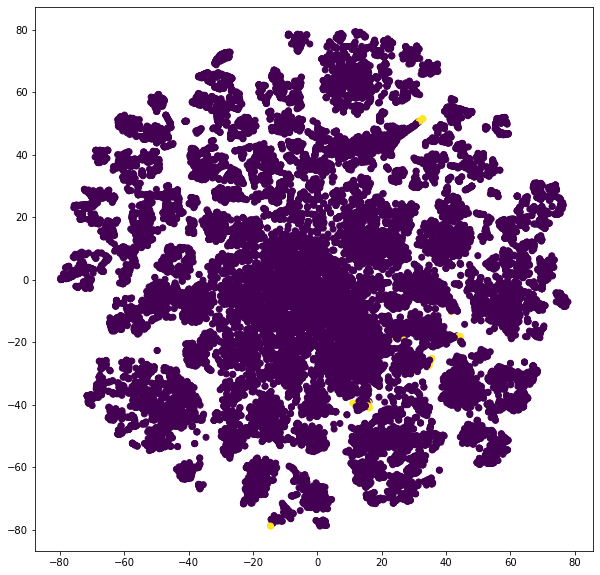

In [30]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=euclidian_outliers);

In [31]:
print(classification_report(data.Class, euclidian_outliers))
confusion_matrix(data.Class, euclidian_outliers)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481



array([[28384,    48],
       [   48,     1]], dtype=int64)

У нас всего одно верное угадывание и 48 ложноотрицательных меток.

Попробуем посчитать с манхэттеновским расстоянием.

In [32]:
citiblock_model = DistanceOutliers(metric='cityblock', percentile=100-percent_expert_score)
citiblock_model.fit(scaled_data)
cityblock_outliers = citiblock_model.predict(scaled_data)
anomalies_report(cityblock_outliers)

labeled_data = data_features.copy()
labeled_data['is_outlier'] = cityblock_outliers

Total number of outliers: 49
Percentage of outliers:   0.17%


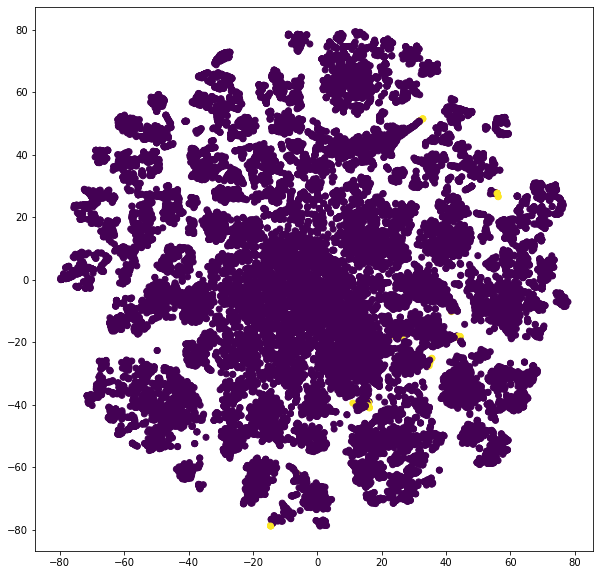

In [33]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=cityblock_outliers);

In [34]:
print(classification_report(data.Class, cityblock_outliers))
confusion_matrix(data.Class, cityblock_outliers)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.18      0.18      0.18        49

    accuracy                           1.00     28481
   macro avg       0.59      0.59      0.59     28481
weighted avg       1.00      1.00      1.00     28481



array([[28392,    40],
       [   40,     9]], dtype=int64)

Здесь модель справилась лучше, но даже 18% это очень мало.

## DBSCAN

Нам нужно определить подходящий epsilon, который обеспечит заданный процент аномалий.

In [35]:
%%time
from sklearn.cluster import DBSCAN

# для начала считаем все наблюдения аномальными
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# берем маленький эпсилон и начинаем увеличивать
eps = 20.2
eps_history = [eps]
while outlier_percentage>expert_score:
    print("eps: ",eps)
    model = DBSCAN(eps=eps, n_jobs=-1).fit(scaled_data)
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    # считаем текущий процент "шума"
    outlier_percentage = sum(labels==1) / len(labels)    
    print("outlier_percentage: ",outlier_percentage)
    eps += 0.1
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)
    
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])

eps:  20.2
outlier_percentage:  0.0017555563358028158
eps:  20.3
outlier_percentage:  0.0017204452090867595
Wall time: 1min 19s


In [36]:
anomalies_report(density_outlier)

Total number of outliers: 49
Percentage of outliers:   0.17%


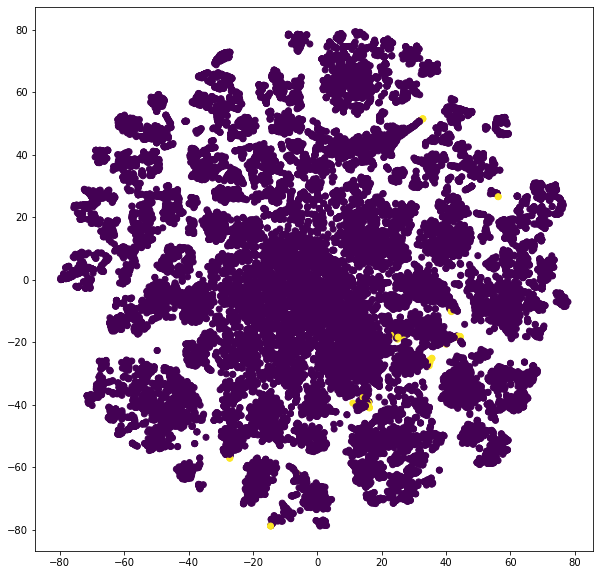

In [37]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=density_outlier);

In [38]:
print(classification_report(data.Class, density_outlier))
confusion_matrix(data.Class, density_outlier)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.08      0.08      0.08        49

    accuracy                           1.00     28481
   macro avg       0.54      0.54      0.54     28481
weighted avg       1.00      1.00      1.00     28481



array([[28387,    45],
       [   45,     4]], dtype=int64)

Всего 4 попадания, низкий результат.

### One Class SVM

In [39]:
%%time
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=expert_score, gamma='auto')
one_class_svm.fit(scaled_data)
svm_outliers = one_class_svm.predict(scaled_data)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

Wall time: 4.83 s


In [40]:
anomalies_report(svm_outliers)

Total number of outliers: 739
Percentage of outliers:   2.59%


Несмотря на указание экспертной оценки аномалий параметром nu, этот метод выявил их существенно больше.

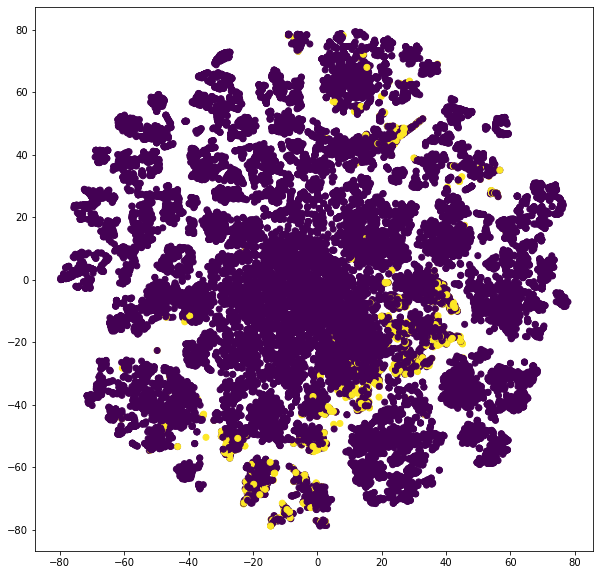

In [41]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=svm_outliers);

In [42]:
print(classification_report(data.Class, svm_outliers))
confusion_matrix(data.Class, svm_outliers)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     28432
           1       0.03      0.43      0.05        49

    accuracy                           0.97     28481
   macro avg       0.51      0.70      0.52     28481
weighted avg       1.00      0.97      0.99     28481



array([[27714,   718],
       [   28,    21]], dtype=int64)

Метрики качества слабые, ложноположительных срабатываний недопустимо много.

### Isolation Forest

In [43]:
%%time
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, contamination=expert_score, 
                                   max_features=1.0, bootstrap=True, behaviour="new")
isolation_forest.fit(scaled_data)

isolation_outliers = isolation_forest.predict(scaled_data)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

C:\Users\andsi\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


Wall time: 3.37 s


In [44]:
anomalies_report(isolation_outliers)

Total number of outliers: 49
Percentage of outliers:   0.17%


Этот метод выявляет точно указанное число аномалий.

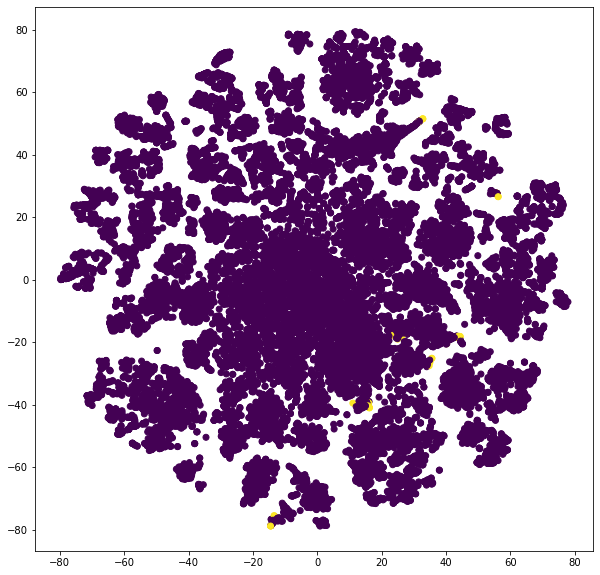

In [45]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=isolation_outliers);

In [46]:
print(classification_report(data.Class, isolation_outliers))
confusion_matrix(data.Class, isolation_outliers)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.10      0.10      0.10        49

    accuracy                           1.00     28481
   macro avg       0.55      0.55      0.55     28481
weighted avg       1.00      1.00      1.00     28481



array([[28388,    44],
       [   44,     5]], dtype=int64)

С метриками, к сожалению, всё тоже печально, только 5 угадываний.

In [47]:
summary = np.concatenate((
    [std_outliers], 
    [iqr_outliers], 
    [euclidian_outliers], 
    [cityblock_outliers],
    
    [svm_outliers],
    [isolation_outliers]
))

summary = pd.DataFrame(
    summary.T, 
    columns=['std', 'iqr', 'euclid', 'cityblock',  'svm', 'isolation']
)
summary.head()

,std,iqr,euclid,cityblock,svm,isolation
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,1,1,0,0,0,0


In [48]:
summary.sum()

std          3705
iqr          5353
euclid         49
cityblock      49
svm           739
isolation      49
dtype: int64

### Заключение

Ни один из методов не показал приемлемой точности прогноза аномалий. Прежде всего это связано с нехваткой вычислительных мощностей компьютера, так как мы ограничили выборку в 10%. Скорее всего, на полной выборке DBSCAN и Isolation Forest сработали бы гораздо лучше.